In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image

import os

In [37]:
class MRLDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = transforms.Compose([transforms.Resize([24, 24]),
                                              transforms.ToTensor()]) 
        self.img_paths = []
        self.img_labels = []

        # Traverses all subfolders and stores the path and label of each training example
        subfolders = os.listdir(path)
        for folder in subfolders:
            p = os.path.join(path, folder)

            if os.path.isdir(p):                                                    # ignores documentation files
                imgs = os.listdir(p)

                for file_name in imgs:
                    self.img_paths.append(os.path.join(p, file_name))               # append image path
                    self.img_labels.append(int(file_name.split("_")[4]))            # append eye state label
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB") 
        img = self.transforms(img)
        label = self.img_labels[idx]

        return (img, label)


In [38]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(90, 24)
        self.fc2 = nn.Linear(24, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 90)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
def evaluate(model, loader, criterion = None):
    total_losses = 0
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        
        # Track total loss
        if criterion:
            loss = criterion(outputs, labels)
            total_losses += loss.item()

        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    if criterion:
        return total_losses/(i+1), total_correct/total_examples 
    else:
        return total_correct/total_examples

In [40]:
def train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []


    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)                     # forward pass

            loss = criterion(outputs, labels)           # calculate loss
            loss.backward()                             # calculate gradients using backprop
            optimizer.step()                            # apply optimizer step
            optimizer.zero_grad()                       # zero the gradients

        # Calculate and record loss/accuracy values
        [l, a] = evaluate(model, train_loader, criterion)
        train_losses.append(l)
        train_acc.append(a)

        [l, a] = evaluate(model, valid_loader, criterion)
        valid_losses.append(l)
        valid_acc.append(a)

        iters.append(epoch)

        print("Epoch:", epoch)

        
    # Plot training curves
    plt.title("Training Curve - Loss")
    plt.plot(iters, train_losses, label = "Training")
    plt.plot(iters, valid_losses, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(valid_losses[-1]))
    print()

    plt.title("Training Curve - Accuracy")
    plt.plot(iters, train_acc, label = "Training")
    plt.plot(iters, valid_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [41]:
# Create Dataset object
dataset = MRLDataset("./Datasets/MRL")       # Pass in root folder of dataset

# Random split (60-20-20)
n = len(dataset)
n_train = int(0.6 *n)
n_valid = int(0.2 *n)
n_test = n - n_train - n_valid

[train_set, valid_set, test_set] = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

"""
# 10% of datasets
train_set = torch.utils.data.Subset(train_set, range(int(0.5 * len(train_set))))
valid_set = torch.utils.data.Subset(valid_set, range(int(0.5 * len(valid_set))))
test_set = torch.utils.data.Subset(test_set, range(int(0.5 * len(test_set))))
"""

# Create DataLoaders
batch_size = 32
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29


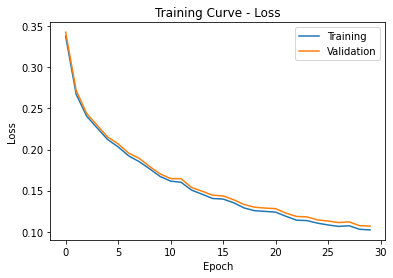

Final Training Loss: 0.10219138278216404
Final Validation Loss: 0.10685062104671239



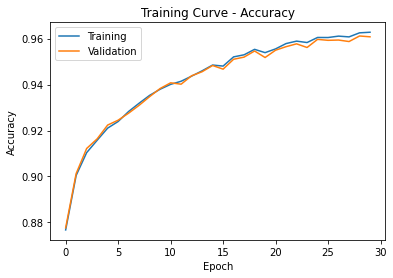

Final Training Accuracy: 0.9627586477678747
Final Validation Accuracy: 0.9607750750927616


In [42]:
model = EyeClassifier()

train(model, train_loader, valid_loader, learning_rate = 0.0001, num_epochs = 30)

In [44]:
evaluate(model, test_loader)

0.9607796949531829

In [ ]:
0.9746